In [11]:
# Install libraries
!pip install prophet
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)


In [2]:
# Load the dataset
df = pd.read_csv('/content/Retail and wherehouse Sale.csv')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              30000 non-null  int64  
 1   MONTH             30000 non-null  int64  
 2   SUPPLIER          29967 non-null  object 
 3   ITEM CODE         30000 non-null  object 
 4   ITEM DESCRIPTION  30000 non-null  object 
 5   ITEM TYPE         30000 non-null  object 
 6   RETAIL SALES      29999 non-null  float64
 7   RETAIL TRANSFERS  30000 non-null  float64
 8   WAREHOUSE SALES   30000 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.1+ MB
None

First 5 rows:
   YEAR  MONTH                           SUPPLIER ITEM CODE  \
0  2020      1  REPUBLIC NATIONAL DISTRIBUTING CO    100009   
1  2020      1                          PWSWN INC    100024   
2  2020      1            RELIABLE CHURCHILL LLLP      1001   
3  2020      1          LAN

In [3]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Handle missing values if any exist
df.fillna(0, inplace=True)

# Convert date columns to datetime format
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str) + '-01')

# Create total sales column
df['TOTAL_SALES'] = df['RETAIL SALES'] + df['RETAIL TRANSFERS'] + df['WAREHOUSE SALES']

# Drop unnecessary columns
df = df.drop(['ITEM CODE', 'ITEM DESCRIPTION', 'SUPPLIER'], axis=1)

# Verify changes
print("\nCleaned dataset info:")
print(df.info())


Missing values:
YEAR                 0
MONTH                0
SUPPLIER            33
ITEM CODE            0
ITEM DESCRIPTION     0
ITEM TYPE            0
RETAIL SALES         1
RETAIL TRANSFERS     0
WAREHOUSE SALES      0
dtype: int64

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   YEAR              30000 non-null  int64         
 1   MONTH             30000 non-null  int64         
 2   ITEM TYPE         30000 non-null  object        
 3   RETAIL SALES      30000 non-null  float64       
 4   RETAIL TRANSFERS  30000 non-null  float64       
 5   WAREHOUSE SALES   30000 non-null  float64       
 6   DATE              30000 non-null  datetime64[ns]
 7   TOTAL_SALES       30000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 1.8+ MB
None


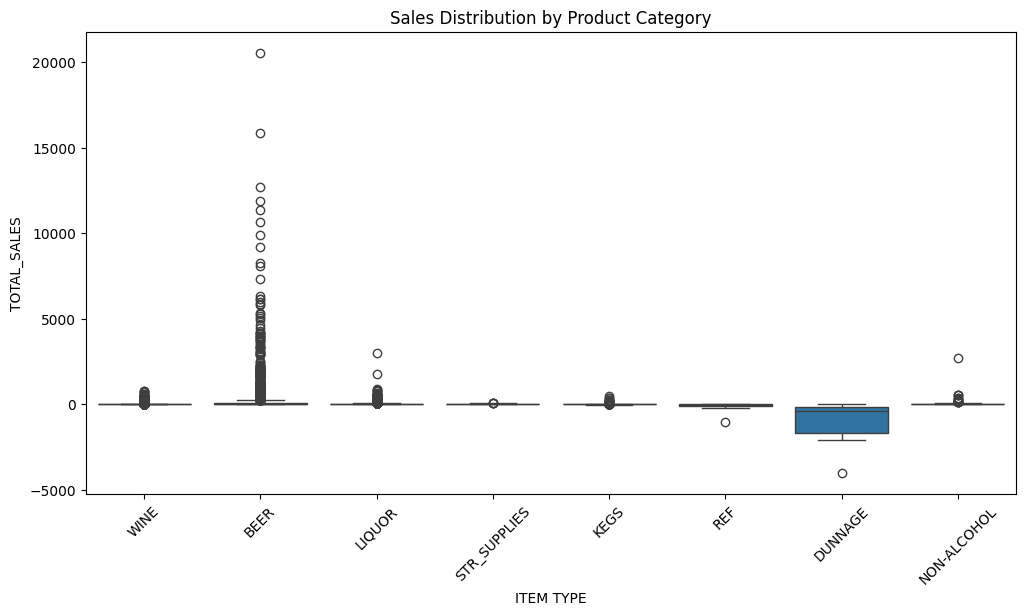

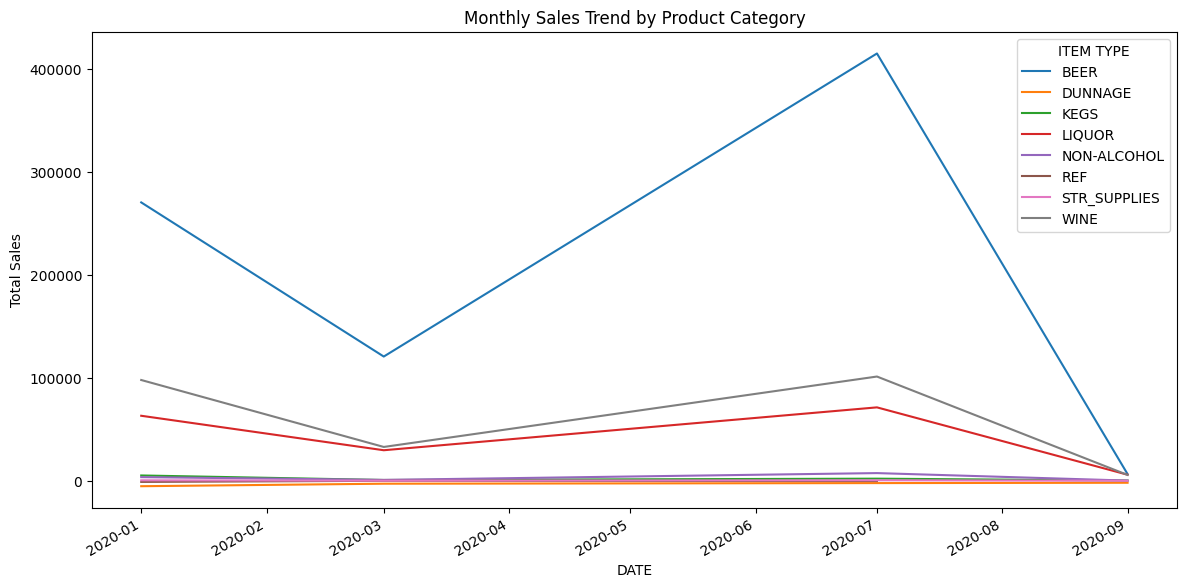

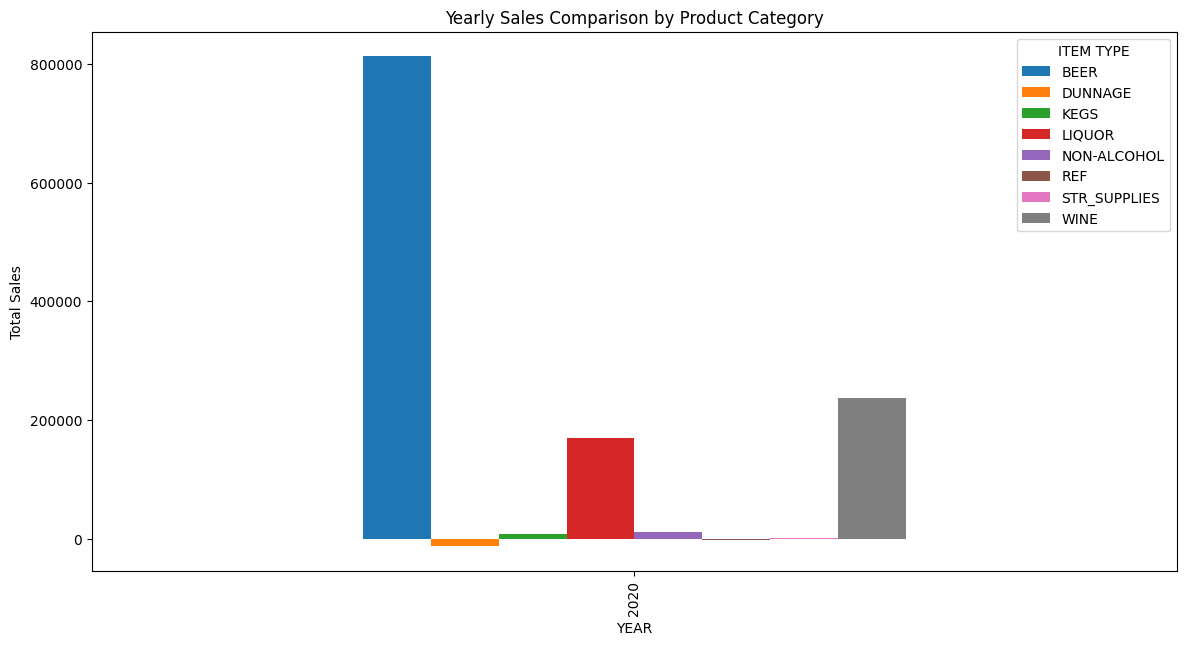

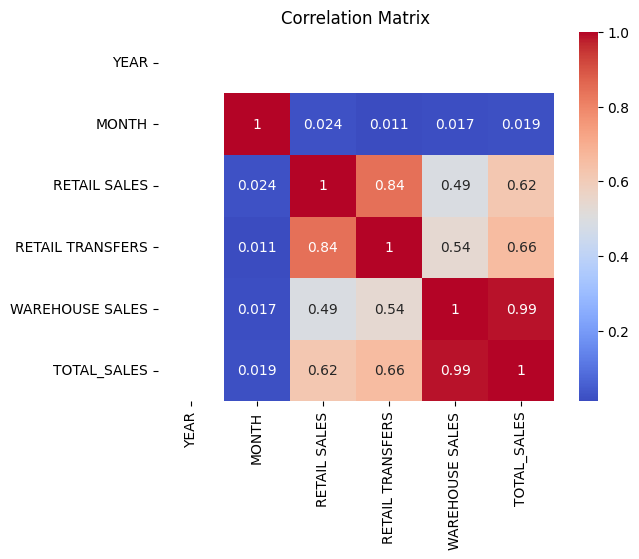

In [4]:
# Sales distribution by item type
plt.figure(figsize=(12,6))
sns.boxplot(x='ITEM TYPE', y='TOTAL_SALES', data=df)
plt.title('Sales Distribution by Product Category')
plt.xticks(rotation=45)
plt.show()

# Monthly sales trend
monthly_sales = df.groupby(['DATE', 'ITEM TYPE'])['TOTAL_SALES'].sum().unstack()
monthly_sales.plot(figsize=(14,7))
plt.title('Monthly Sales Trend by Product Category')
plt.ylabel('Total Sales')
plt.show()

# Yearly sales comparison
yearly_sales = df.groupby(['YEAR', 'ITEM TYPE'])['TOTAL_SALES'].sum().unstack()
yearly_sales.plot(kind='bar', figsize=(14,7))
plt.title('Yearly Sales Comparison by Product Category')
plt.ylabel('Total Sales')
plt.show()

# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Decompose time series for each product category
for item_type in df['ITEM TYPE'].unique():
    item_sales = df[df['ITEM TYPE'] == item_type].groupby('DATE')['TOTAL_SALES'].sum()
    if len(item_sales) > 12:  # Need at least 2 periods for seasonal decomposition
        decomposition = seasonal_decompose(item_sales, model='additive', period=12)
        decomposition.plot()
        plt.suptitle(f'Time Series Decomposition for {item_type}')
        plt.show()

In [8]:
# Create time-based features
df['MONTH_NUM'] = df['DATE'].dt.month
df['QUARTER'] = df['DATE'].dt.quarter
df['YEAR'] = df['DATE'].dt.year

# Create lag features (example for 1 month lag)
df.sort_values(['ITEM TYPE', 'DATE'], inplace=True)
df['LAG_1'] = df.groupby('ITEM TYPE')['TOTAL_SALES'].shift(1)

# Create rolling statistics (3-month moving average)
df['ROLLING_MEAN_3'] = df.groupby('ITEM TYPE')['TOTAL_SALES'].transform(lambda x: x.rolling(3, 1).mean())

# Drop rows with NA values created by lag features
df.dropna(inplace=True)

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['ITEM TYPE', 'MONTH_NUM', 'QUARTER'], drop_first=True)

# Verify final dataset
print("\nFinal dataset for modeling:")
print(df.head())


Final dataset for modeling:
    YEAR  MONTH  RETAIL SALES  RETAIL TRANSFERS  WAREHOUSE SALES       DATE  \
7   2020      1          0.00               0.0              2.0 2020-01-01   
33  2020      1          0.00               0.0              9.0 2020-01-01   
41  2020      1          2.00               2.0              0.0 2020-01-01   
42  2020      1          2.75               2.0              7.0 2020-01-01   
43  2020      1          0.00               0.0              5.0 2020-01-01   

    TOTAL_SALES  LAG_1  ROLLING_MEAN_3  ITEM TYPE_DUNNAGE  ITEM TYPE_KEGS  \
7          2.00   1.00        1.500000              False           False   
33         9.00   2.00        4.000000              False           False   
41         4.00   9.00        5.000000              False           False   
42        11.75   4.00        8.250000              False           False   
43         5.00  11.75        6.916667              False           False   

    ITEM TYPE_LIQUOR  ITEM TYPE_N


Random Forest Performance:
MAE: 1.6306889481580271
RMSE: 27.540889937324526


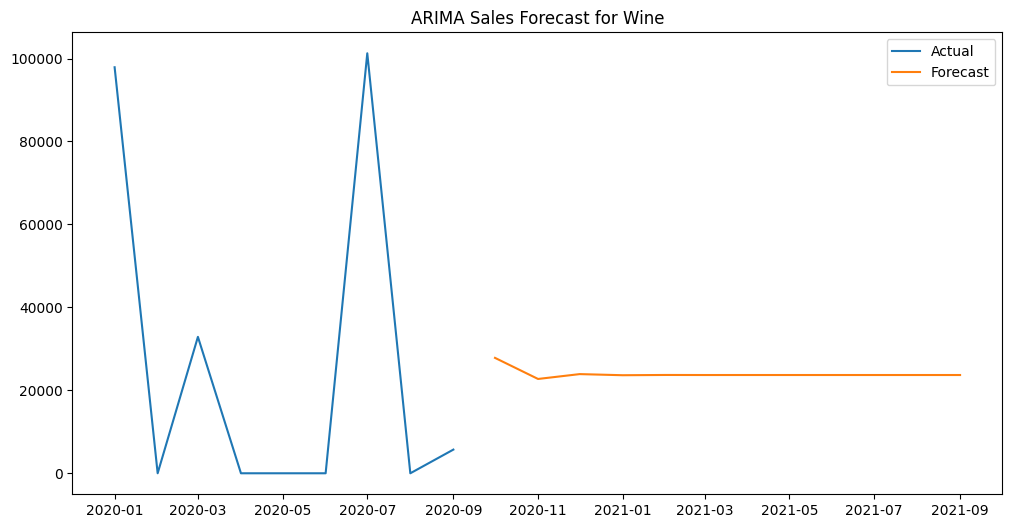

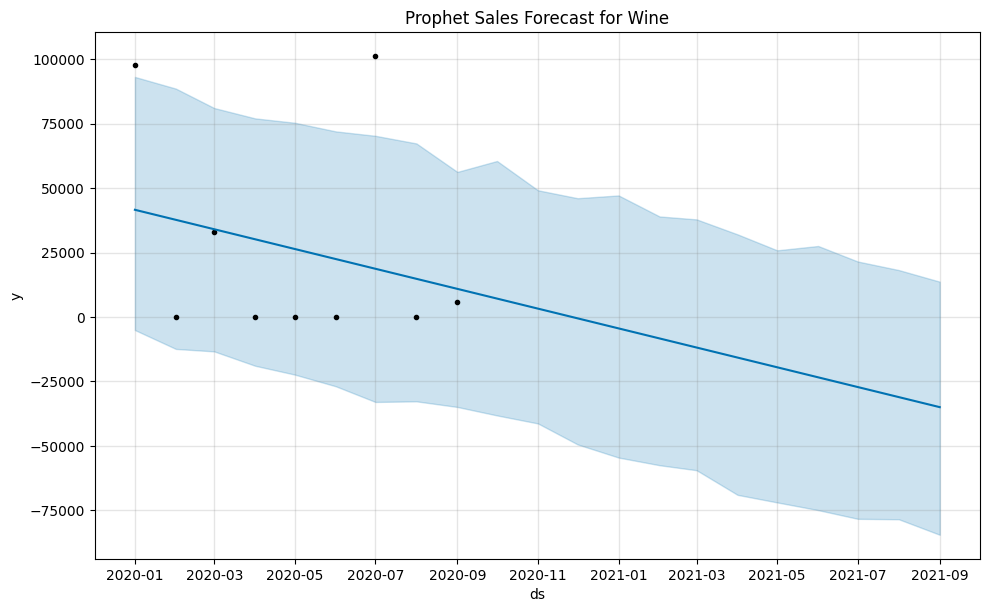

In [12]:
# Sales Forecasting Models
# Split data into train and test sets
X = df.drop(['TOTAL_SALES', 'DATE'], axis=1)
y = df['TOTAL_SALES']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Evaluate Random Forest
print("\nRandom Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, rf_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred))}")

# ARIMA Model (for one product category example)
wine_sales = df[df['ITEM TYPE_WINE'] == 1].groupby('DATE')['TOTAL_SALES'].sum()
wine_sales = wine_sales.asfreq('MS').fillna(0)

# Fit ARIMA model
arima_model = ARIMA(wine_sales, order=(1,1,1))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=12)

# Plot ARIMA results
plt.figure(figsize=(12,6))
plt.plot(wine_sales, label='Actual')
plt.plot(arima_pred, label='Forecast')
plt.title('ARIMA Sales Forecast for Wine')
plt.legend()
plt.show()

# Prophet Model (for one product category example)
prophet_df = wine_sales.reset_index()
prophet_df.columns = ['ds', 'y']
prophet_model = Prophet(seasonality_mode='multiplicative')
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=12, freq='MS')
prophet_forecast = prophet_model.predict(future)

# Plot Prophet results
fig = prophet_model.plot(prophet_forecast)
plt.title('Prophet Sales Forecast for Wine')
plt.show()

In [13]:
#7: Marketing Spend Optimization
# This is a placeholder - in a real scenario you would need marketing spend data
# Here simulate the optimization process

from scipy.optimize import minimize

# Simulate marketing-sales relationship (in reality, this would come from your data)
def sales_response(marketing_spend, product_type):
    """Simulated sales response to marketing spend"""
    if product_type == 'WINE':
        return 100 * (1 - np.exp(-0.002 * marketing_spend))
    elif product_type == 'LIQUOR':
        return 120 * (1 - np.exp(-0.0018 * marketing_spend))
    else:  # BEER
        return 80 * (1 - np.exp(-0.0022 * marketing_spend))

# Objective function to maximize total sales
def objective(x):
    wine_spend, liquor_spend, beer_spend = x
    total_sales = (sales_response(wine_spend, 'WINE') +
                   sales_response(liquor_spend, 'LIQUOR') +
                   sales_response(beer_spend, 'BEER'))
    return -total_sales  # Negative because we minimize in scipy

# Constraints
total_budget = 100000  # Total marketing budget
constraints = (
    {'type': 'eq', 'fun': lambda x: sum(x) - total_budget},  # Total spend = budget
    {'type': 'ineq', 'fun': lambda x: x[0]},  # Wine spend >= 0
    {'type': 'ineq', 'fun': lambda x: x[1]},  # Liquor spend >= 0
    {'type': 'ineq', 'fun': lambda x: x[2]}   # Beer spend >= 0
)

# Initial guess (equal allocation)
x0 = [total_budget/3, total_budget/3, total_budget/3]

# Optimize
result = minimize(objective, x0, method='SLSQP', constraints=constraints)

# Display results
optimal_spend = result.x
print("\nOptimal Marketing Spend Allocation:")
print(f"Wine: ${optimal_spend[0]:.2f}")
print(f"Liquor: ${optimal_spend[1]:.2f}")
print(f"Beer: ${optimal_spend[2]:.2f}")
print(f"Expected Total Sales: ${-result.fun:.2f}")


Optimal Marketing Spend Allocation:
Wine: $33333.33
Liquor: $33333.33
Beer: $33333.33
Expected Total Sales: $300.00


In [14]:
# Save models for deployment
import joblib

# Save Random Forest model
joblib.dump(rf_model, 'sales_forecast_rf_model.pkl')

# Save ARIMA model (for wine example)
joblib.dump(arima_result, 'wine_sales_arima_model.pkl')

# Save Prophet model
joblib.dump(prophet_model, 'wine_sales_prophet_model.pkl')

# Save column names for inference
with open('model_columns.pkl', 'wb') as f:
    joblib.dump(X.columns.tolist(), f)

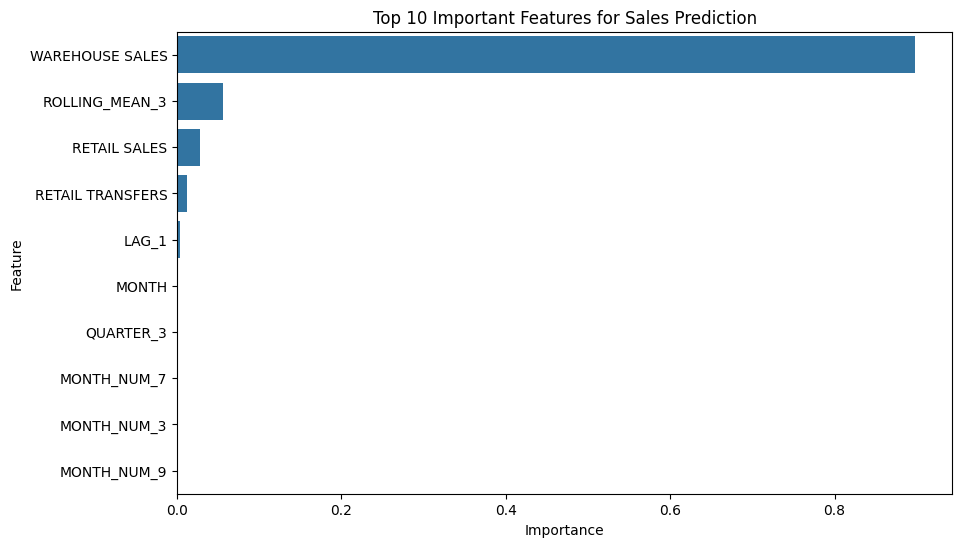


Business Recommendations:
1. Allocate marketing budget according to the optimal distribution calculated
2. Focus on product categories with higher sales response to marketing spend
3. Consider seasonal patterns when planning marketing campaigns
4. Monitor lagging indicators (previous months' sales) for better forecasting
5. Regularly update models with new data to maintain accuracy


In [15]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features for Sales Prediction')
plt.show()

# Business recommendations
print("\nBusiness Recommendations:")
print("1. Allocate marketing budget according to the optimal distribution calculated")
print("2. Focus on product categories with higher sales response to marketing spend")
print("3. Consider seasonal patterns when planning marketing campaigns")
print("4. Monitor lagging indicators (previous months' sales) for better forecasting")
print("5. Regularly update models with new data to maintain accuracy")